In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

df = pd.read_csv('data/who.csv')

In [16]:
df = df.drop(columns=['iso2', 'iso3'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7240 entries, 0 to 7239
Data columns (total 58 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country       7240 non-null   object 
 1   year          7240 non-null   int64  
 2   new_sp_m014   3173 non-null   float64
 3   new_sp_m1524  3209 non-null   float64
 4   new_sp_m2534  3206 non-null   float64
 5   new_sp_m3544  3219 non-null   float64
 6   new_sp_m4554  3223 non-null   float64
 7   new_sp_m5564  3218 non-null   float64
 8   new_sp_m65    3209 non-null   float64
 9   new_sp_f014   3174 non-null   float64
 10  new_sp_f1524  3194 non-null   float64
 11  new_sp_f2534  3200 non-null   float64
 12  new_sp_f3544  3199 non-null   float64
 13  new_sp_f4554  3204 non-null   float64
 14  new_sp_f5564  3195 non-null   float64
 15  new_sp_f65    3197 non-null   float64
 16  new_sn_m014   1045 non-null   float64
 17  new_sn_m1524  1030 non-null   float64
 18  new_sn_m2534  1022 non-null 

#### Question 1. We need to know what's included in this data.
- How many countries are present?  
- What's the timespan of the data?  
- Does each country have a row for every year present?  
- Which countries are missing years?  
- How many rows have at least 1 non-null values across the columns 3-57?

In [17]:
countries = len(set(df['country']))
print(f'Number of countries: {countries}')

Number of countries: 219


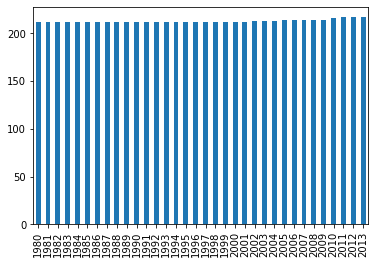

In [18]:
df.year.value_counts().sort_index().plot.bar()
plt.show()

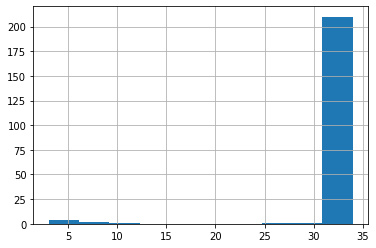

Country List:


Netherlands Antilles                 30
Serbia & Montenegro                  25
Timor-Leste                          12
Montenegro                            9
Serbia                                9
Sint Maarten (Dutch part)             4
Bonaire, Saint Eustatius and Saba     4
Curacao                               4
South Sudan                           3
Name: country, dtype: int64

In [19]:
df['country'].value_counts().hist(bins=10)
plt.show()

print('Country List:')
x = df['country'].value_counts()
x[x<x.max()]

In [20]:
nullCount = df.iloc[:, 3:df.shape[1]].isnull().min(axis=1).sum()
print(f'Rows with at all null: {nullCount:,}')

Rows with at all null: 3,756


#### Question 2: Wide data isn't usually helpful.
Convert this to a long format with the following columns:  
1. country  
2. year  
3. diagnosis method: mapping should be: 

  {'newsp':'Pulmonary Smear (+)'
  ,'newsn':'Pulmonary Smear (-)'
  ,'newep':'Extrapulmonary'
  ,'newrel':'Relapse'}   
  

4. gender: male or female.   
5. age: lower_age - higher_age, e.g., 0-14  
6. number of cases  

In [21]:
meltDf = (
    df.melt(id_vars=['country','year'])
)

meltDf.head()

,country,year,variable,value
0,Afghanistan,1980,new_sp_m014,NaN
1,Afghanistan,1981,new_sp_m014,NaN
2,Afghanistan,1982,new_sp_m014,NaN
3,Afghanistan,1983,new_sp_m014,NaN
4,Afghanistan,1984,new_sp_m014,NaN


In [22]:
meltDf.shape

(405440, 4)

Parse newly reformatted data to extract the method, gender, and age groups

In [23]:
meltDf = (
    df.melt(id_vars=['country','year'])
)

meltDf.head()

dMethod = {'newsp': 'Pulmonary Smear (+)',
           'newsn': 'Pulmonary Smear (-)',
           'newep':'Extrapulmonary',
           'newrel':'Relapse'}

ageGroups = {'014': '0-14', '1524': '15-24', '2534': '25-34', '3544':'35-44', '4554':'45-54','5564':'55-64','65':'65+'}

# split elements into a list
meltDf = meltDf.assign(varList = meltDf.variable.apply(lambda x: x.split('_')))

# join elements 1 to N-1 together and isolate the age
meltDf = meltDf.assign(var12 = meltDf.varList.apply(lambda x: ''.join(x[0:-1])), 
                       genderAge = meltDf.varList.apply(lambda x: x[-1])
                      )

# Extract the age
meltDf['ageStr'] = meltDf.genderAge.str[1:]

# map the diagnosis
meltDf['diagnosis_method'] = meltDf.var12.map(dMethod)

# Extract the gender
meltDf['gender'] = np.where(meltDf.genderAge.str.startswith('m'),'Male','Female')
# map the age groups
meltDf['age'] = meltDf.ageStr.map(ageGroups)

meltDf.head()

,country,year,variable,value,varList,var12,genderAge,ageStr,diagnosis_method,gender,age
0,Afghanistan,1980,new_sp_m014,NaN,"[new, sp, m014]",newsp,m014,014,Pulmonary Smear (+),Male,0-14
1,Afghanistan,1981,new_sp_m014,NaN,"[new, sp, m014]",newsp,m014,014,Pulmonary Smear (+),Male,0-14
2,Afghanistan,1982,new_sp_m014,NaN,"[new, sp, m014]",newsp,m014,014,Pulmonary Smear (+),Male,0-14
3,Afghanistan,1983,new_sp_m014,NaN,"[new, sp, m014]",newsp,m014,014,Pulmonary Smear (+),Male,0-14
4,Afghanistan,1984,new_sp_m014,NaN,"[new, sp, m014]",newsp,m014,014,Pulmonary Smear (+),Male,0-14


Clean-up

In [24]:
meltDf = meltDf[['country','year','diagnosis_method','gender','age','value']]
meltDf = meltDf.rename(columns={'value':'cases'})
meltDf.head()

,country,year,diagnosis_method,gender,age,cases
0,Afghanistan,1980,Pulmonary Smear (+),Male,0-14,NaN
1,Afghanistan,1981,Pulmonary Smear (+),Male,0-14,NaN
2,Afghanistan,1982,Pulmonary Smear (+),Male,0-14,NaN
3,Afghanistan,1983,Pulmonary Smear (+),Male,0-14,NaN
4,Afghanistan,1984,Pulmonary Smear (+),Male,0-14,NaN


In [25]:
meltDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405440 entries, 0 to 405439
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   country           405440 non-null  object 
 1   year              405440 non-null  int64  
 2   diagnosis_method  405440 non-null  object 
 3   gender            405440 non-null  object 
 4   age               405440 non-null  object 
 5   cases             76046 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 18.6+ MB


In [26]:
meltDf.gender.value_counts()

Male      202720
Female    202720
Name: gender, dtype: int64

In [27]:
meltDf.age.value_counts()

15-24    57920
0-14     57920
55-64    57920
65+      57920
45-54    57920
25-34    57920
35-44    57920
Name: age, dtype: int64

In [28]:
meltDf.diagnosis_method.value_counts()

Relapse                101360
Extrapulmonary         101360
Pulmonary Smear (-)    101360
Pulmonary Smear (+)    101360
Name: diagnosis_method, dtype: int64

#### Question 3: Create a graph that shows when countries started to report TB cases.

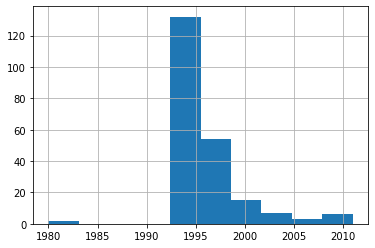

In [29]:
meltDf.query('cases.notna()', engine='python').groupby('country')['year'].min().hist()
plt.show()